In [2]:
#hide
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [482]:
# hide

import requests
response = requests.get('https://docs.google.com/spreadsheet/ccc?key=1M7uDgWSfy6z1MNbC9FP6jTNgvY7XchJ0m-BfW88SKtQ&output=csv')
assert response.status_code == 200, 'Wrong status code'
from io import StringIO
import pandas as pd

df = pd.read_csv(StringIO(response.content.decode('utf8')))

In [483]:
df = df[1:].copy()

In [484]:
from datetime import datetime, date

df['date'] = df.Fecha.apply(lambda x: datetime.strptime(x, '%d/%m/%Y').date())

In [485]:
df['enfermos'] = df.Casos - df.Recuperados.fillna(0)

In [486]:
df = df[~df.Casos.isna()]

In [518]:
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import numpy as np
import matplotlib.dates as mdates
import statsmodels.api as sm

def exp_fit(cut_point=date(2020, 3, 20), start_point=None, log_scale=False, fit_intercept=True, field='Casos'):
    if start_point is None:
        skip_samples = 0        
        cases = df.set_index('date')[field][:cut_point]
    else:
        skip_samples = df.date.tolist().index(start_point)
        cases = df.set_index('date')[field][start_point: cut_point]

    x = np.arange(len(cases))
    mc = 0 if fit_intercept else np.log(cases.values.min())
    y = np.log(cases.values) - mc
    
    lr = LinearRegression(fit_intercept=fit_intercept)
    lr.fit(x.reshape((-1,1)), y)

    print(f'coef: {np.exp(lr.coef_[0]):.02f}, constant:{np.exp(lr.intercept_):.02f}')
    forecast = np.exp(
        lr.predict(
            np.arange(-skip_samples, len(df) + 3 - skip_samples).reshape((-1, 1))
        ) + mc
    )

    df.set_index('date')[field].plot(style='-o')
    for doc in df.to_dict(orient='records'):
        text_y = doc[field] * 1.5 if log_scale else doc[field] + 100 
        plt.text(
            doc['date'], text_y , 
            int(doc[field]), bbox=dict(boxstyle='round', facecolor='white', alpha=0.5),
            horizontalalignment='center'
        )
        
    cases.plot(style='-o', label='Casos usados para el modelo')   
    dates = [e.date() for e in pd.date_range(df.date.min(), df.date.max() + timedelta(days=3))]
    pd.Series(forecast, index=dates).plot(label='Predicción', style='-o', alpha=0.6)

    plt.vlines(cut_point, 1, forecast.max(), linestyle='--')
    plt.fill_between(
        [cut_point, df.date.max() + timedelta(days=3 + skip_samples)], 
        1, forecast.max(), color='k', alpha=0.2
    )
    plt.text(
        cut_point + timedelta(days=2), 
        df[field].max() * (0.05 if log_scale else 1.4), 
        'Cuarentena', 
        fontdict=dict(size=20)
    )

    plt.legend(loc='best')
    if log_scale: plt.yscale('log')
    
    plt.ylim(1, forecast.max() * 1.1)
    plt.xlim(df.date.min(), df.date.max() + timedelta(days=3 + skip_samples))
    ax = plt.gca()
    # set monthly locator
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    # set formatter
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    # set font and rotation for date tick labels
    plt.xticks(rotation=30)
    
    y = df.set_index('date')[field]
    if start_point: y = y[start_point:]
    y = y.values
    return np.abs((np.exp(lr.predict(np.arange(len(y)).reshape((-1, 1))) + mc) - y) / y).mean()


coef: 1.24, constant:9.84
0.0701800985002238
coef: 1.24, constant:9.84


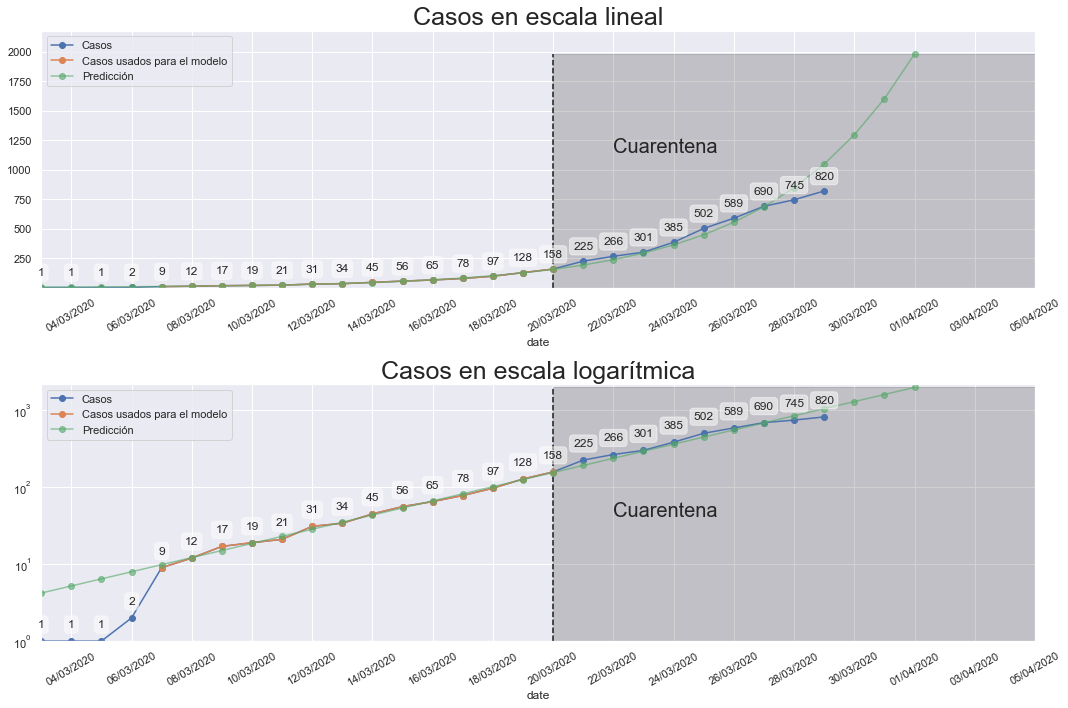

In [519]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.title('Casos en escala lineal', fontdict=dict(size=25))
print(exp_fit(start_point=date(2020, 3, 7), field='Casos'))
plt.subplot(212)
plt.title('Casos en escala logarítmica', fontdict=dict(size=25))
exp_fit(start_point=date(2020, 3, 7), log_scale=True, field='Casos');
plt.tight_layout()

coef: 1.25, constant:1.00
0.08237318071089345
coef: 1.25, constant:1.00


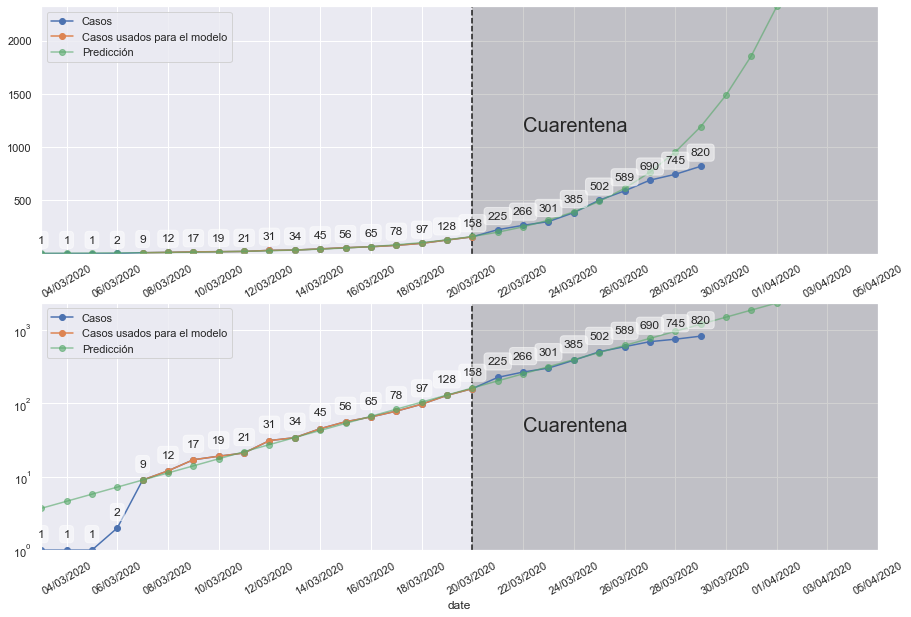

In [517]:
plt.figure(figsize=(15,10))
plt.subplot(211)
print(exp_fit(start_point=date(2020, 3, 7), fit_intercept=False, field='Casos'))
plt.subplot(212)
exp_fit(start_point=date(2020, 3, 7), log_scale=True, fit_intercept=False, field='Casos');

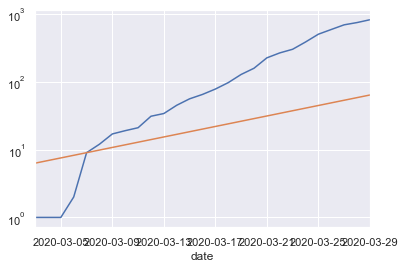

In [390]:
y_hat = [np.exp(model.predict(results.params, e - 4) + np.log(y).min())[0]  for e in np.arange(len(df))]
df['forecast'] = y_hat

df.set_index('date').Casos.plot(logy=True)
df.set_index('date').forecast.plot(logy=True)

In [374]:
cut_point=date(2020, 3, 20)
start_point=date(2020, 3, 7)
log_scale=False
fit_intercept=True

if start_point is None:
    skip_samples = 0        
    cases = df.set_index('date').Casos[:cut_point]
else:
    skip_samples = df.date.tolist().index(start_point)
    cases = df.set_index('date').Casos[start_point:cut_point]

x = np.arange(len(cases))
mc = 0 if fit_intercept else np.log(cases.values.min())
y = cases.values

((y - 9 * 1.2486801511109675 ** x) ** 2).sum()




122.83393145459368

coef: 0.22, constant:1.00
coef: 0.22, constant:1.00


781.6338418565185

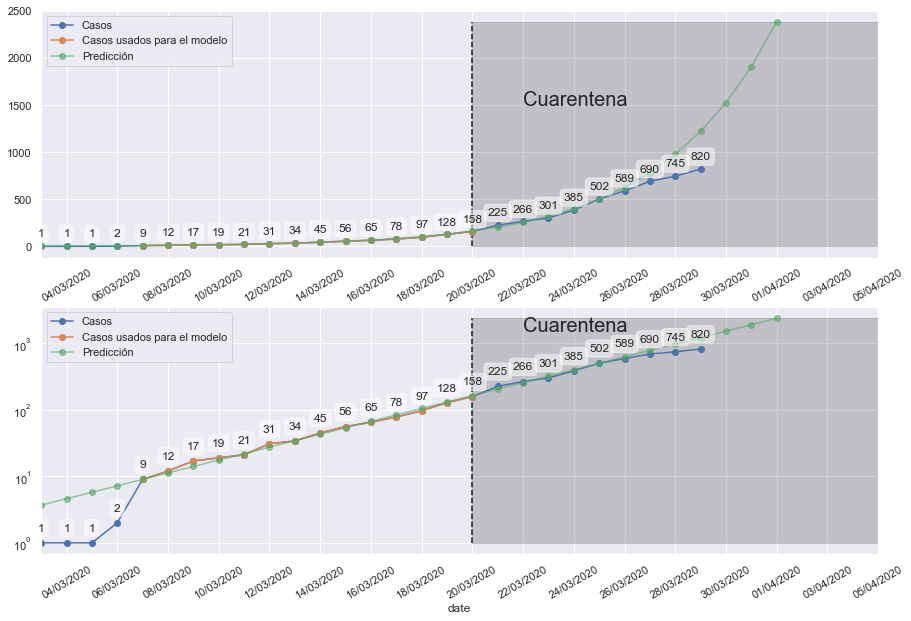

In [313]:
plt.figure(figsize=(15,10))
plt.subplot(211)
exp_fit(start_point=date(2020, 3, 7), fit_intercept=False)
plt.subplot(212)
exp_fit(start_point=date(2020, 3, 7), log_scale=True, fit_intercept=False)

In [15]:
from sklearn.linear_model import LinearRegression
import numpy as np

cutpoint = datetime(2020, 3, 20)

cases = df.set_index('date').Casos
    X = c_df.days_from_tenth_infection.values.reshape((-1,1)) - c_df.days_from_tenth_infection.min()
    y_orig = c_df.confirmed.values
    y = np.log(y_orig + 1)

    lr = LinearRegression(fit_intercept=True)
    lr.fit(X, y)

    X_fore = np.linspace(X.min(), X.max() + 4 + end, len(X) + 4 + end)
    y_forecast = np.exp(lr.predict(X_fore.reshape((-1, 1)))) - 1
    
    x_pred = X_fore + c_df.days_from_tenth_infection.min()
    
    return {
        'forecast': y_forecast, 
        'infected': full_c_df.confirmed.max(),
        'fore': list(map(int, y_forecast[-4:])),
        'x_pred': x_pred, 
        'coef_': lr.coef_[0], 
        'intercept_': lr.intercept_, 
        'mae': np.abs(((y_orig - np.exp(lr.predict(X)) - 1) / y_orig)).mean(),
#         'days': days, 
        'country': country,
        'last_day': c_df.date.max()
    }

In [44]:
import requests
response = requests.get('https://docs.google.com/spreadsheet/ccc?key=1M7uDgWSfy6z1MNbC9FP6jTNgvY7XchJ0m-BfW88SKtQ&output=csv')
assert response.status_code == 200, 'Wrong status code'
from io import StringIO

pd.read_csv(StringIO(response.content.decode('utf8')))

,Fecha,Casos,Fallecidos,Recuperados,Terapia,Tests Malbran,Unnamed: 6,Descartados por investigación epidemiológica,Unnamed: 8,Unnamed: 9,...,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Acumulados,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,NaN,NaN,NaN,NaN,NaN,Negativos,Totales,NaN,NaN,Fecha,...,Transmisión Comunitaria,En estudio,Tests negativos,Total,Fecha,Importados,Contacto estrecho / Conglomerado,Transmisión Comunitaria,En estudio,Total
1,3/3/2020,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3/3/2020,...,NaN,NaN,NaN,1,3/3/2020,1,0,0,0,1
2,4/3/2020,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4/3/2020,...,NaN,NaN,NaN,0,4/3/2020,1,0,0,0,1
3,5/3/2020,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5/3/2020,...,NaN,NaN,NaN,0,5/3/2020,1,0,0,0,1
4,6/3/2020,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,6/3/2020,...,NaN,NaN,NaN,2,6/3/2020,3,0,0,0,3
5,7/3/2020,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7/3/2020,...,NaN,NaN,NaN,6,7/3/2020,9,0,0,0,9
6,8/3/2020,12.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,8/3/2020,...,NaN,NaN,NaN,3,8/3/2020,12,0,0,0,12
7,9/3/2020,17.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,9/3/2020,...,NaN,NaN,NaN,5,9/3/2020,17,0,0,0,17
8,10/3/2020,19.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,10/3/2020,...,NaN,NaN,NaN,2,10/3/2020,19,0,0,0,19
9,11/3/2020,21.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,11/3/2020,...,NaN,NaN,NaN,2,11/3/2020,21,0,0,0,21


In [40]:
 c_df.set_index('date').confirmed[-30:].

{Timestamp('2020-03-01 00:00:00'): 0,
 Timestamp('2020-03-02 00:00:00'): 0,
 Timestamp('2020-03-03 00:00:00'): 1,
 Timestamp('2020-03-04 00:00:00'): 1,
 Timestamp('2020-03-05 00:00:00'): 1,
 Timestamp('2020-03-06 00:00:00'): 2,
 Timestamp('2020-03-07 00:00:00'): 8,
 Timestamp('2020-03-08 00:00:00'): 12,
 Timestamp('2020-03-09 00:00:00'): 12,
 Timestamp('2020-03-10 00:00:00'): 17,
 Timestamp('2020-03-11 00:00:00'): 19,
 Timestamp('2020-03-12 00:00:00'): 19,
 Timestamp('2020-03-13 00:00:00'): 31,
 Timestamp('2020-03-14 00:00:00'): 34,
 Timestamp('2020-03-15 00:00:00'): 45,
 Timestamp('2020-03-16 00:00:00'): 56,
 Timestamp('2020-03-17 00:00:00'): 68,
 Timestamp('2020-03-18 00:00:00'): 79,
 Timestamp('2020-03-19 00:00:00'): 97,
 Timestamp('2020-03-20 00:00:00'): 128,
 Timestamp('2020-03-21 00:00:00'): 158,
 Timestamp('2020-03-22 00:00:00'): 225,
 Timestamp('2020-03-23 00:00:00'): 266,
 Timestamp('2020-03-24 00:00:00'): 301,
 Timestamp('2020-03-25 00:00:00'): 387,
 Timestamp('2020-03-26 00:

2020-03-22 00:00:00


(array([737484., 737485., 737489., 737493., 737497., 737501., 737505.,
        737509., 737513., 737516.]),
 <a list of 10 Text xticklabel objects>)

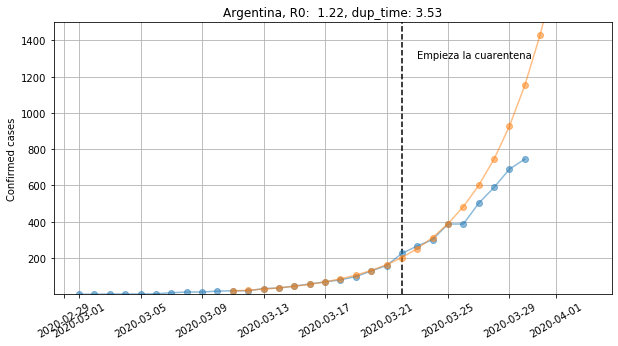

In [35]:
import math
from datetime import timedelta


doc = get_lr('Argentina', 20, 8)

c_df = df[df.country == doc['country']]

plt.figure(figsize=(10,5))

plt.plot(c_df.date[-30:], c_df.confirmed[-30:], '-o', alpha=0.5)
plt.plot(
    [timedelta(days=x) + c_df.tenth_infaction_date.min() for x in doc['x_pred']],
    doc['forecast'], 
    '-o', alpha=0.5
)

plt.vlines(doc['last_day'], 1, doc['forecast'].max(), linestyle='--')
plt.text(doc['last_day'] + timedelta(days=1), 1300, 'Empieza la cuarentena', )
print(doc['last_day'])

plt.ylim(1, 1500)
plt.title(f"{doc['country']}, R0: {doc['coef_'] + 1: .02f}, dup_time: {math.log(2, doc['coef_'] + 1):.02f}")
plt.grid()
plt.ylabel('Confirmed cases')
plt.xticks(rotation=30)
          
# plt.yscale('log')

# Do it for the rest of the world

In [19]:
docs = []
for c, cnt in df.dropna()[df.dropna().confirmed > 0].country.value_counts().to_dict().items():
    if cnt < 20: continue
        
    docs.append(get_lr(c, 10))

In [20]:
docs.sort(key=lambda x: x['mae'])

In [21]:
pd.DataFrame(docs).drop(['forecast', 'x_pred'], axis=1).sort_values('coef_', ascending=False)

,infected,fore,coef_,intercept_,mae,country,last_day
48,859,"[1297, 1681, 2178, 2822]",0.258887,4.580151,0.135512,Dominican Republic,2020-03-29
44,4247,"[6117, 7781, 9898, 12589]",0.240530,6.313846,0.085400,Israel,2020-03-29
32,140886,"[193582, 241723, 301835, 376896]",0.222088,9.952590,0.048664,US,2020-03-29
40,6280,"[8825, 10931, 13539, 16768]",0.213922,6.946347,0.068926,Canada,2020-03-29
19,479,"[612, 753, 925, 1138]",0.206171,4.357891,0.028327,Morocco,2020-03-29
31,1815,"[2299, 2806, 3426, 4181]",0.199280,5.748102,0.047195,Romania,2020-03-29
16,5962,"[7667, 9332, 11359, 13825]",0.196480,6.980095,0.025775,Portugal,2020-03-29
42,901,"[1179, 1431, 1738, 2110]",0.193732,5.136441,0.082863,Panama,2020-03-29
37,1418,"[1570, 1886, 2266, 2722]",0.183294,5.526770,0.055962,Philippines,2020-03-29
45,4256,"[5889, 7059, 8462, 10144]",0.181244,6.868579,0.102186,Brazil,2020-03-29


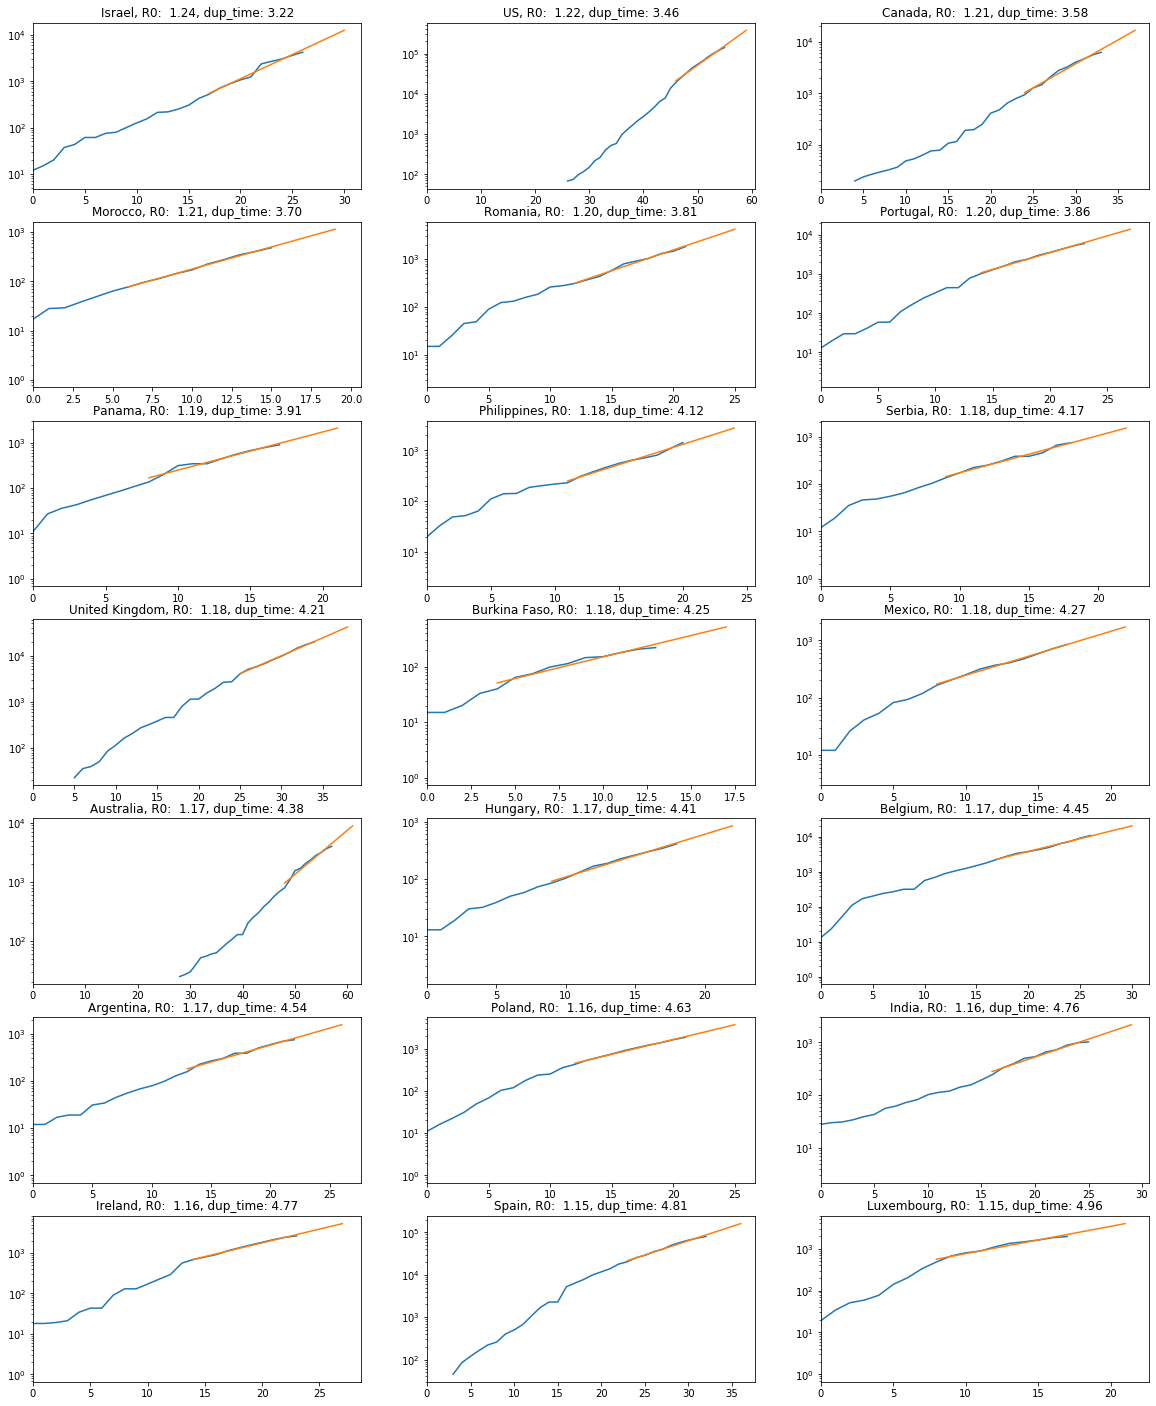

In [22]:
fig, axs = plt.subplots(7, 3, figsize=(20, 25))
axs = axs.reshape(-1)
for i, doc in enumerate([d for d in sorted(docs, key=lambda x: -x['coef_']) if d['mae'] < 0.1][:21]):
    c_df = df[df.country == doc['country']]
    axs[i].semilogy(c_df.days_from_tenth_infection[-30:], c_df.confirmed[-30:])
    axs[i].semilogy(doc['x_pred'], doc['forecast'])
    axs[i].set_xlim(0, axs[i].get_xlim()[1])
    axs[i].set_title(f"{doc['country']}, R0: {doc['coef_'] + 1: .02f}, dup_time: {math.log(2, doc['coef_'] + 1):.02f}")